# From Linear Regression to Neural Networks
These days there exists much hype around sophisticated machine learning methods such as Neural Networks. They are massively powerful models that allow us to fit very flexible models. However, we do not always require the full complexity of a Neural Network: sometimes, a simpler model will do the job just fine. In this project, we take a journey starting from the most fundamental statistical machinery to model data distributions - linear regression and logistic classification - to then explain the benefits of constructing more complex models, such as Support Vector Machines and Neural Networks. We will not shy away from the math, whilst still working with tangible examples at all times: we will work with real world datasets and we'll get to apply our models in code right in this document as we go on. Let's start!

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from enum import Enum
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
!python --version

Python 3.9.2


## Antartican penguins
First, we need some data. A simple dataset that still has enough complexity for our purposes is the **Penguin** [dataset](https://github.com/allisonhorst/penguins) from Antartica LTER \[1\]. Some scientists working in Antartica have measured the flipper length, body mass, nose depth and more of some penguins living there. The dataset includes three species.


In [2]:
data = sns.load_dataset('penguins')
data = data.dropna()
data.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

We can observe there are 4 quantitative columns describing the penguins. The penguin sex, island and species are categorical columns. The *bill* is the penguin's snout: we have variables `bill_depth_mm` and `bill_length_mm`.

![Penguin dimensions](images/penguin-dimensions.png)
<small class="caption">Penguin bill. Courtesy of @allison_horst.</small>

The other quantitative variables are the `flipper_length_mm` (length of penguin flipper in millimeters) and the `body_mass_g` (penguin body mass in grams).

Also, before conducting any experiments, let's split the dataset into a training and testing subset. Splitting the dataset into training and hold-out testing sets is a common practice called Cross Validation - allowing us to get a more reliable estimate of the generalization performance of the estimator. We hold out 1/5th of the data for testing and use the rest for training.

In [3]:
rs = np.random.RandomState(34)
test = rs.choice(data.index, len(data) // 4)
train = data.index[~data.index.isin(test)]
data.loc[train, 'subset'] = 'Train'
data.loc[test, 'subset'] = 'Test'
data_train = data[data['subset'] == 'Train']
data_test = data[data['subset'] == 'Test']
data.groupby('subset').count()[['species']]

,species
subset,
Test,78
Train,255


## Linear Regression
First, let's explore linear regression. Presumably, there might be a relation between some of the quantiative variables and penguin **body mass**.

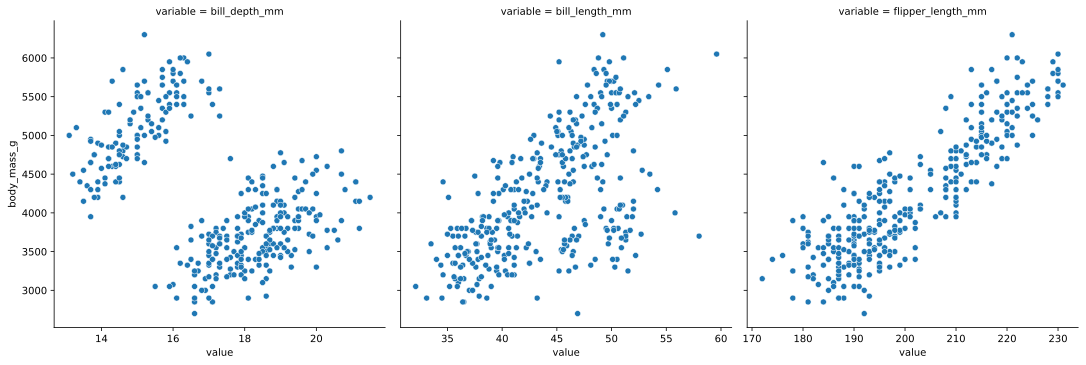

In [4]:
long = data.melt(id_vars=['body_mass_g'],
    value_vars=['bill_depth_mm', 'bill_length_mm', 'flipper_length_mm'])
sns.relplot(data=long, x='value', y='body_mass_g', col='variable',
    facet_kws={'sharex': False})

Body mass seems to correlate with **flipper length**. The longer the penguin flipper length, the heavier it is, generally speaking. Let's see whether we can predict penguin body mass using flipper length by modeling the relationship with linear regression: penguin flipper length will be the independent variable whilst penguin body mass will be the dependent variable.

We can analytically solve Linear Regression by minimizing the *Residual Sum-of-Squares* cost function:

$RSS(\beta) = (y - X \beta)^T (y - X \beta)$

In which $X$ is our *design matrix*. This loss function is also sometimes just referred to as "Ordinary Least Squares".

### Ordinary Least Squares
First, we must build our design matrix. The design matrix contains all explanatory variables with which we would like to predict $y$. To incorporate the data intercept we can include a bias constant of 1 in our design matrix. An alternative would be to first center our data such to get rid of the intercept entirely. We define the design matrix as follows.

In [5]:
def design_matrix(X, Y):
    b = np.ones((len(X), 1))
    X = np.hstack([b, X])
    return X, Y
X = data_train[['flipper_length_mm']].values
Y = data_train[['body_mass_g']].values
X_train, Y_train = design_matrix(X, Y)
X_train.shape, Y_train.shape

((255, 2), (255, 1))



 To now minimize our cost function we differentiate RSS with respect to $\beta$, giving us the following unique minimum:

$\hat{\beta} = (X^T X)^{-1} X^T Y$

In [6]:
β = lambda X, Y: np.linalg.pinv(X.T @ X) @ X.T @ Y
β_train = β(X_train, Y_train)
β_train

array([[-5781.51310866],
       [   49.72704083]])

Which results in the estimated least-squares coefficients given the training data. We can classify by simply multiplying our input data point with the found coefficient matrix: $\hat{y} = X \hat{\beta}$.

Let's see how well we did, quantitatively. We can do this by evaluating the Residual Sum-of-Squares on our observations given regression projection.

In [9]:
MSE = lambda X, Y, β: (np.transpose(Y - X @ β) @ (Y - X @ β) / len(X)).item()
err_train = MSE(X_train, Y_train, β_train)
err_train

162248.872319392

In [ ]:
def predict(x_axis, β):
    x = np.linspace(x_axis.min(), x_axis.max())
    b = np.ones(len(x))
    X = np.vstack([b, x]).T
    ŷ = X @ β
    ŷ = ŷ.flatten()
    return pd.DataFrame({'x': x, 'y': ŷ})
ŷ = predict(data['flipper_length_mm'], β_train)
ŷ.shape

(50, 2)

In [55]:
X = data_test[['flipper_length_mm']].values
Y = data_test[['body_mass_g']].values
X_test, Y_test = design_matrix(X, Y)
err_test = MSE(X_test, Y_test, β_train)
err_test

126389.96201089853

Let's observe our fitted regression line onto the data:

In [54]:
sns.scatterplot(data=data, x='flipper_length_mm', y='body_mass_g',
    hue='subset', alpha=0.3, hue_order=['Train', 'Test'])
sns.lineplot(data=ŷ, x='x', y='y')
plt.xlabel('Flipper length (millimeters)')
plt.ylabel('Body mass (grams)')
plt.title('Penguin Flipper length vs Body mass \n'+
    f'MSE: train = {err_train:.2e}, test = {err_test:.2e}')


(50, 2)

We are also ought to compute the MSE on the **testing** data hold-out set.

We observe that the testing error is very close to the training error; it has even lower average error. That said, the line fits the data quite well - the error is of acceptable margins. Let's also plot the fitted line.

The line fits pretty nicely, and we are now able to predict penguin body mass given its flipper length 💪🏻.

### High-dimensional data
The dataset we fit the regression on was pretty easy - perhaps a drastic oversimplification in comparison to the real world. In the real world, datasets might be of very high dimensionality: think of images, speech, or a biomedical dataset storing DNA sequences.

So, let's simulate a high-dimensional situation, in which the amount of dimensions far outmatches the amount of dataset samples ($p \gg n$). We will simply copy the dataset columns and add some noise to them to make them different.

In [57]:
# X = data_train[['flipper_length_mm']].values
# Y = data_train[['body_mass_g']].values
# def augment(X, p):
#     X = np.repeat(X, [p], axis=1)
#     ε = rs.normal(size=X.shape, scale=2.0)
#     X = X + ε
#     return X
# X = augment(X, 1000)
# X_train, Y_train = design_matrix(X, Y)
# X_train.shape, Y_train.shape

In [58]:
# %%timeit -r 5 -n 5
# β(X_train, Y_train)

Oww. That took quite a while. Computing matrix inverses on large dimensional matrices is a very slow operation. We can do faster - using a more approximate, iterative procedure: **Gradient Descent**.

### Gradient Descent
To iteratively solve linear regression for high-dimensional datasets, we might use Gradient Descent. It works by computing the gradient of the cost function with respect to the model weights - such that we can then move in the opposite direction of the gradient in parameter space. To facilitate gradient descent we first introduce some new code abstractions.

### [WIP] Ridge Regression

In [59]:
MSE(X_train, Y_train, β_train)

162248.872319392

In [60]:
X = data_test[['flipper_length_mm']].values
Y = data_test[['body_mass_g']].values
X = augment(X, 2000)
X_test, Y_test = design_matrix(X, Y)
X_test.shape, Y_test.shape

NameError: name 'augment' is not defined

In [ ]:
MSE(X_test, Y_test, β_train)

393923.8323605847

In [ ]:
def βridge(X, Y, λ = 1.0):
    n, p = X.shape
    L2 = λ * np.identity(p)
    βridge = np.linalg.pinv(X.T @ X + L2) @ X.T @ Y
    return βridge
βridge_train = βridge(X_train, Y_train)
βridge_train

array([[-1.01783166],
       [-1.35572194],
       [-2.27172563],
       ...,
       [ 0.07480297],
       [-4.50050847],
       [ 0.62873583]])

In [ ]:
MSE(X_train, Y_train, βridge_train)

0.007658212234735176

In [ ]:
MSE(X_test, Y_test, βridge_train)

393901.3775711893

## Polynomial Regression


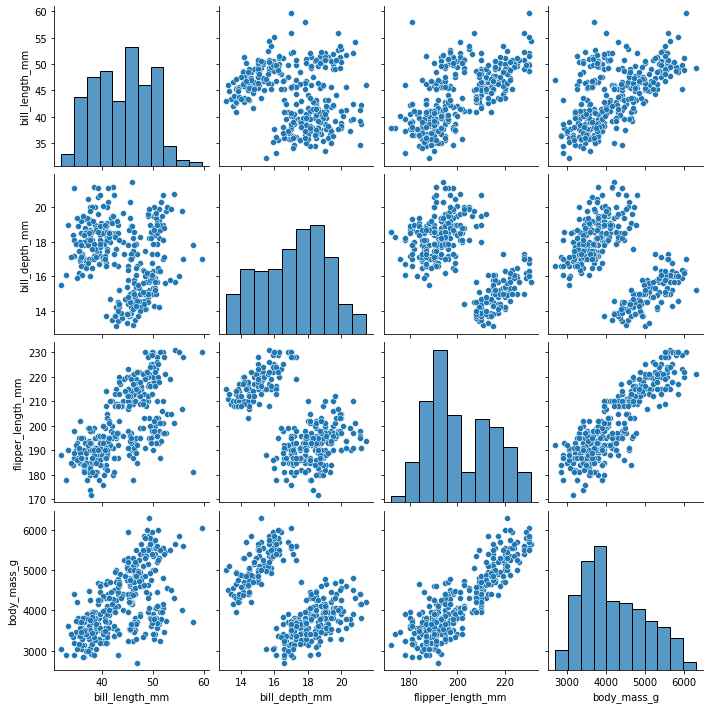

In [ ]:
sns.pairplot(data=data)

<AxesSubplot:xlabel='flipper_length_mm', ylabel='body_mass_g'>

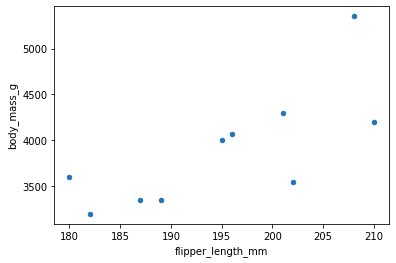

In [ ]:
data_train.sample(10, random_state=34).plot.scatter(
    x='flipper_length_mm', y='body_mass_g')


In [ ]:
data_train.sample(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,subset
321,Gentoo,Biscoe,55.9,17.0,228.0,5600.0,Male,Train
258,Gentoo,Biscoe,44.0,13.6,208.0,4350.0,Female,Train
56,Adelie,Biscoe,39.0,17.5,186.0,3550.0,Female,Train
328,Gentoo,Biscoe,43.3,14.0,208.0,4575.0,Female,Train
90,Adelie,Dream,35.7,18.0,202.0,3550.0,Female,Train
185,Chinstrap,Dream,51.0,18.8,203.0,4100.0,Male,Train
107,Adelie,Biscoe,38.2,20.0,190.0,3900.0,Male,Train
93,Adelie,Dream,39.6,18.1,186.0,4450.0,Male,Train
33,Adelie,Dream,40.9,18.9,184.0,3900.0,Male,Train
73,Adelie,Torgersen,45.8,18.9,197.0,4150.0,Male,Train


## Logistic Regression

## Citations
- [Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081.](https://doi.org/10.1371/journal.pone.0090081)